In [1]:
%load_ext ipython_sparql_pandas
from SPARQLWrapper import SPARQLWrapper, JSON
sparql = SPARQLWrapper('http://DESKTOP-CELL0BF:7200/repositories/20qsmall')
sparql.setReturnFormat(JSON)

In [ ]:
import rdflib
import html
from SPARQLWrapper import SPARQLWrapper, JSON
g = rdflib.Graph().parse('./fb15k-wikitop2021-yago-facts.nt', format='ntriples')
g += rdflib.Graph().parse('./fb15k-wikitop2021-yago-full-types.nt', format='ntriples')

from rdflib.namespace import RDF
for line in open('fb15k-wikitop2021.tsv').readlines()[1:]:
    subject = rdflib.URIRef( line.split('\t')[6][1:-1] ) # take the URI in column 6
    g.add( (subject, RDF.type, rdflib.URIRef('http://example.com/popularEntity')) )
    
g.remove((None, rdflib.URIRef('http://schema.org/image') , None))
g.remove((None, rdflib.URIRef('http://schema.org/url') , None))


<Graph identifier=Nb9f15f1ea6d741d8856c10be668c652f (<class 'rdflib.graph.Graph'>)>

In [ ]:
subject='http://yago-knowledge.org/resource/David_Bowie'
attributes=[]
query = f"""
select  ?p ?o
where {{
<{subject}> ?p ?o .}}"""

results = g.query(query)
for b in results:
    attributes.append(f'{subject}, {b.p}, {b.o}')
print(attributes)

['http://yago-knowledge.org/resource/David_Bowie, http://schema.org/award, http://yago-knowledge.org/resource/100_Greatest_Britons', 'http://yago-knowledge.org/resource/David_Bowie, http://schema.org/award, http://yago-knowledge.org/resource/Saturn_Award_for_Best_Actor', 'http://yago-knowledge.org/resource/David_Bowie, http://schema.org/award, http://yago-knowledge.org/resource/Grammy_Hall_of_Fame', "http://yago-knowledge.org/resource/David_Bowie, http://schema.org/award, http://yago-knowledge.org/resource/Rolling_Stone's_100_Greatest_Artists_of_All_Time", 'http://yago-knowledge.org/resource/David_Bowie, http://schema.org/award, http://yago-knowledge.org/resource/Grammy_Lifetime_Achievement_Award', 'http://yago-knowledge.org/resource/David_Bowie, http://schema.org/award, http://yago-knowledge.org/resource/Order_of_the_British_Empire', 'http://yago-knowledge.org/resource/David_Bowie, http://schema.org/award, http://yago-knowledge.org/resource/Rock_and_Roll_Hall_of_Fame', 'http://yago-kn

In [ ]:
query = f"""
SELECT ?s ?p ?o
WHERE {{
?s ?p ?o .
    FILTER(?s = <http://yago-knowledge.org/resource/David_Bowie>)
    FILTER(?p = <http://schema.org/alumniOf>)
    FILTER(?o = <http://yago-knowledge.org/resource/Ravensbourne_University_London>)
    }}
    """
results=g.query(query)
print(len(results)>0)
p

In [5]:
#from the query results extract a list that contains the counts after splitting on certain attributes
import re
PosAttr=['?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .', '?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.']
NegAttr=[]
AttrHistory = ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']

def prepareProps(popEntities):
    Distribution = {}
    for i in popEntities:
        Distribution[i]= 1/len(popEntities)
    return Distribution


def extractCountAndAttr(result):
    number = []
    listOfObj = []
    listOfPred= []
    for attr in result["results"]["bindings"]:
        listOfObj.append(attr['o'])
        listOfPred.append(attr['p'])
    #print(listOfObj[0])
    return(listOfObj,listOfPred)


  
def updateQuery(left, PosFilters, NegFilters):
    FilterQuestion =  (f"""
            select (count(*) as ?count) ?p ?o  where 
            {{
            {PosFilters}
             ?s ?p ?o .
            {NegFilters}
            }} 
            group by ?p ?o 
            ORDER BY ABS( {left/2} - ?count )
            """) 
        
    return FilterQuestion

In [6]:
def numberleft_disable(PosFilters,NegFilters):
    query =  f"""
            select (count(?s) as ?count) where 
            {{
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
            {PosFilters}{NegFilters} 
          }}       
            group by ?p ?o 
            ORDER BY DESC(?count )            
            """ 
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    qres = sparql.query().convert() 
    for r in qres["results"]["bindings"]:
        left= (r["count"]["value"])
        return(int(left))
    
def popentities(PosFilters,NegFilters):
    query =  f"""
            select ?s where 
            {{
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
            {PosFilters}
            {NegFilters} 
            }}
            """ 
    results = g.query(query)
    ents=[]
    for b in results:
        ents.append(f'{b.s}')
    return ents


In [7]:
def prepareProps(popEntities):
    Distribution = {}
    for i in popEntities:
        Distribution[i] = 1
        #Distribution[i]= 1/len(popEntities)
    return Distribution
    

def findPosAndNeg(listOfObj, listOfPred, index):
    Filter = '?s <' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>.'
    negFilter='FILTER NOT EXISTS {{ \n ?s <' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>. }}'
    EntitiesPositive = popentities(Filter, "")
    EntitiesNegative = popentities("", negFilter)
    return (EntitiesPositive, EntitiesNegative)
    
                       
def findSplits():
    possibleObj=[]
    possiblePred =[]
    count = []
    query =  f"""
            select (count(?s) as ?count)   ?o ?p
            {{               
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
        ?s ?p ?o.
            }}
        group by  ?o ?p
        ORDER BY desc ( ?count )
            """ 
    results = g.query(query)
    count=[]
    possibleObj=[]
    possiblePred=[]
    for b in results:
        count.append(f'{b.count}')
        possibleObj.append(f'{b.o}')
        possiblePred.append(f'{b.p}')   
    return (possibleObj, possiblePred, count)

def determineBestSplit(possibleObj, possiblePred, count):
    bestSplit=-1
    indexBestSplit = -1
    #branches = range(2,250)
    #for i in random.sample(branches, 40): 
    for i in range(350):
        #Fix The nummerical thing here::: (skip over i if nummer)
        if str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>') in AttrHistory:
            continue
        else:
            Yes = pos.get(str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>'))
            No = negs.get(str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>'))
            OccurenceYes = len(Yes)
            OccurenceNo=len(No)
            """Yes, No = findPosAndNeg(possibleObj, possiblePred, i)
            OccurenceYes=len(Yes)
            OccurenceNo=len(No)"""
            WeightYes=0
            WeightNo=0
            for y in Yes:
                WeightYes+=Distribution[y]
            for n in No:
                WeightNo+=Distribution[n]
            SumWeights=WeightYes+WeightNo
            ProbabilityYes=WeightYes/SumWeights
            ProbabilityNo=WeightNo/SumWeights
            Entropy = - (ProbabilityYes * math.log(ProbabilityYes+0.0001,2) + ProbabilityNo * math.log(ProbabilityNo+0.0001,2))
            #print(str(possiblePred[i]) +'> <'+str(possibleObj[i]), Entropy)
            if Entropy > bestSplit:
                bestSplit=Entropy
                indexBestSplit=i
    #print(bestSplit, possibleObj[indexBestSplit], possiblePred[indexBestSplit])
    return(indexBestSplit, bestSplit)

def WrongAnswerRate(answer, chance):
    if randint(0,100)<chance:
        print("haha fooled!")
        if answer:
            answer=False
        else:
            answer=True
    return(answer)
        
def wrongAnswerList( amount):
    l = []
    i = -1
    for i in range(20-amount):
        l.append(True)
    for i in range(amount):
        l.append(False)
    random.shuffle(l)
    return(l, i)

def retrieveAnswer(answer, l, i):
    i+=1
    if l[i]:
        return(answer, i)
    else:
        print("wrong answer incoming")
        return(not answer, i)
"""preparePops
enter loop
find splits, determine best split, generate question (update probabilities)"""
                             
                             
        


'preparePops\nenter loop\nfind splits, determine best split, generate question (update probabilities)'

In [8]:
def generateHumanQuestion(listOfObj, listOfPred, index, subject, Distribution):
    
    AttrHistory.append('<' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>')
    answer = input(f'Does the thing you are looking for have the attribute: {listOfPred[index].split("/")[-1]} {listOfObj[index].split("/")[-1]}?' )
    
    Yes, No = findPosAndNeg(listOfObj, listOfPred, index)
    if answer.startswith('y'):   
        for y in Yes:
            Distribution[y]= Distribution[y]*0.8
        for n in No:
            Distribution[n]= Distribution[n]*0.2
            
    else:
        for y in Yes:
            Distribution[y] = Distribution[y]*0.2
        for n in No:
            Distribution[n] = Distribution[n]*0.8
            
    print(Distribution[subject])
    return Distribution

def allSubjects(qres, ind):
    attributes=[]
    subject=qres[ind]
    query = f"""
    select  ?p ?o
    where {{
    <{subject}> ?p ?o .}}"""
    results = g.query(query)
    for b in results:
        attributes.append(f'{subject}, {b.p}, {b.o}')
    return(subject, attributes)

def loadSubjects():

    query = f"""
    select distinct ?s
    where {{
        ?s ?p ?o .
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
        ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
    }}
    """
    results = g.query(query)
    ents=[]
    for b in results:
        ents.append(f'{b.s}')
    return ents
     
def pickSubject(qres):
    ind=randint(0,134)
    pick = qres[ind]
    return pick
    """for r in qres["results"]["bindings"][ind:ind+1]:
        return("<"+r["s"]["value"]+">")"""

def findAnswer(subject,p,o):
    query = f"""
        SELECT ?s ?p ?o
        WHERE {{
        ?s ?p ?o .
            FILTER(?s = <{subject}>)
            FILTER(?p = <{p}>)
            FILTER(?o = <{o}>)
            }}
            """
    results=g.query(query)
    return(len(results)>0)

In [9]:
def generateBotQuestionManipulate(listOfObj, listOfPred, index, subject, Distribution,itteration, attribu):
    AttrHistory.append('<' + str(listOfPred[index]) +'> <'+str(listOfObj[index])+ '>')
    print(f'Does the thing you are looking for have the attribute: {listOfPred[index].split("/")[-1]} {listOfObj[index].split("/")[-1]}?' )
    if f'{subject}, {listOfPred[index]}, {listOfObj[index]}'in attribu:
        answer=True
    else:
        answer=False
    #answer = findAnswer(subject, str(listOfPred[index]),str(listOfObj[index]))
    """if itteration in [17,18,19]:
        answer = not answer"""
    #answer = WrongAnswerRate(answer, 10)

    answer, initilaizeCount = retrieveAnswer(answer, answerPattern,i-1)
    print(answer)
    Yes, No = findPosAndNeg(listOfObj, listOfPred, index)
    """OccurenceYes=len(Yes)
    OccurenceNo=len(No)
    NEntities=OccurenceYes+OccurenceNo
    ProbabilityYes=OccurenceYes/NEntities
    ProbabilityNo=OccurenceNo/NEntities"""

    if answer:   
        for y in Yes:
            Distribution[y]= Distribution[y]*0.9
        for n in No:
            Distribution[n]= Distribution[n]*0.1
            
    else:
        for y in Yes:
            Distribution[y] = Distribution[y]*0.1
        for n in No:
            Distribution[n] = Distribution[n]*0.9
            
    print(Distribution[subject])
    return Distribution

In [10]:
def loadAllAttributes(possibleObj,possiblePred):
    EntsPerAttribute={}
    EntsWithoutAttribute={}
    for i in range(350):
        Yes, No = findPosAndNeg(possibleObj, possiblePred, i)

        attr=str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>')
        EntsPerAttribute[attr]=Yes
        EntsWithoutAttribute[attr]=No
    return(EntsPerAttribute, EntsWithoutAttribute)


"""possibleObj, possiblePred, count = findSplits()
pos, negs= loadAllAttributes(possibleObj,possiblePred)"""

'possibleObj, possiblePred, count = findSplits()\npos, negs= loadAllAttributes(possibleObj,possiblePred)'

In [12]:
%%time
#without printing results
from random import randint
import random
import math
import time 
wincount = 0
gamesplayed = 0
wrongAnswersPerQuestion = 3
totalgames = 134
Entrop_over_game = []
list_losses=[]
list_wins=[]

possibleObj, possiblePred, count = findSplits()
pos,negs = loadAllAttributes(possibleObj,possiblePred)
qres = loadSubjects()

while gamesplayed < totalgames:
    answerPattern, initilaizeCount = wrongAnswerList(wrongAnswersPerQuestion)
    Entropies=[]
    AttrHistory= ['<http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity>']
    # Resets all variables
    i=0
    outofguess = []
    # pick subject
    #subject = pickSubject(qres)
    subject, attribu = allSubjects(qres, gamesplayed)
    print("\n" , subject)
    popularEntities =  popentities("\n".join(PosAttr),"")
    Distribution = prepareProps(popularEntities)
    
    while i < 20:

        # list of Pred and Obj for questions
        #listOfObj ,listOfPred = extractCountAndAttr(qres)

        # if only 1 popular entity is left break


        # ask question and add filters to query
        print('Question: %s' %(i+1))

        indexSplit, Entropy=determineBestSplit(possibleObj, possiblePred, count)
        Distribution = generateBotQuestionManipulate(possibleObj, possiblePred, indexSplit,subject, Distribution, i, attribu)
        i+=1
        Entropies.append(Entropy)
    # Prints answer
    #print(Distribution)
    highProb=-1
    for j in Distribution.values():
        if j > highProb:
            highProb=j
    answer = list(Distribution.keys())[list(Distribution.values()).index(highProb)]
    print("The Answer is: ", answer, "With a Probability of: ", highProb)
    print(subject)
    if str(answer.split("/")[-1]) == str(subject.split("/")[-1]):
        wincount +=1
        #list_wins.append(answerPattern)
    #else:
        
        #list_losses.append(answerPattern)
    gamesplayed+=1
    Entrop_over_game.append(Entropies)

    
print("\nTournament ended! I have guessed " + str(wincount) + " out of " + str(gamesplayed) + " things correctly.")


 http://yago-knowledge.org/resource/Elizabeth_II
Question: 1
Does the thing you are looking for have the attribute: hasOccupation Actor?
False
0.9
Question: 2
Does the thing you are looking for have the attribute: nationality United_States?
False
0.81
Question: 3
Does the thing you are looking for have the attribute: nationality United_Kingdom?
True
0.7290000000000001
Question: 4
Does the thing you are looking for have the attribute: hasOccupation Singer-songwriter?
wrong answer incoming
True
0.0729
Question: 5
Does the thing you are looking for have the attribute: award Order_of_the_British_Empire?
False
0.06561
Question: 6
Does the thing you are looking for have the attribute: hasOccupation Pianist?
False
0.059049000000000004
Question: 7
Does the thing you are looking for have the attribute: hasOccupation Politician?
False
0.05314410000000001
Question: 8
Does the thing you are looking for have the attribute: hasOccupation Stage_actor?
False
0.04782969000000001
Question: 9
Does the t

http://schema.org/hasOccupation
http://yago-knowledge.org/resource/Elizabeth_II


False


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

xax = numpy.array(range(0,134))
for i in dis_over_time:
    yax=[]
    for j in i:
        yax.append(j)
    plt.plot(xax, yax)
plt.show

color = plt.cm.rainbow(np.linspace(0, 1, len(dis_over_time)))
for i, c in zip(range(len(dis_over_time)), color):
    yax=dis_over_time[i]
    plt.plot(xax, yax, c=c)

In [ ]:
yax = []
xax = numpy.array(range(0,134))

for j in range(9):
    yax = []
    for i in analyse_dis[j].values():
        yax.append(i)
    plt.plot(xax, yax)
    plt.show()

In [ ]:
from random import randint
import random
import math
import time 

possibleObj, possiblePred, count = findSplits()
popularEntities =  popentities("\n".join(PosAttr),"")
Distribution = prepareProps(popularEntities)


bestSplit=-1
indexBestSplit = -1
#branches = range(2,250)
#for i in random.sample(branches, 30): 
for i in range(25):
    #Fix The nummerical thing here::: (skip over i if nummer)
    if str('<' + str(possiblePred[i]) +'> <'+str(possibleObj[i])+ '>') in AttrHistory:
        continue
    else:
        Yes, No = findPosAndNeg(possibleObj, possiblePred, i)
        OccurenceYes=len(Yes)
        OccurenceNo=len(No)
        WeightYes=0
        WeightNo=0
        for y in Yes:
            WeightYes+=Distribution[y]
        for n in No:
            WeightNo+=Distribution[n]
        SumWeights=WeightYes+WeightNo
        ProbabilityYes=WeightYes/SumWeights
        ProbabilityNo=WeightNo/SumWeights
        Entropy = - (ProbabilityYes * math.log(ProbabilityYes+0.0001,2) + ProbabilityNo * math.log(ProbabilityNo+0.0001,2))
        print(Entropy, possiblePred[i], possibleObj[i])
        #print(str(possiblePred[i]) +'> <'+str(possibleObj[i]), Entropy)
        if Entropy > bestSplit:
            bestSplit=Entropy
            indexBestSplit=i
#print(bestSplit, possibleObj[indexBestSplit], possiblePred[indexBestSplit])
print(bestSplit, indexBestSplit)

In [33]:
list_wins

[[True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  True],
 [True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False],
 [True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False],
 [True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 [True,
  False,
  True,
  True,
  True,
  True,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  True,
  True,
  True],
 [True,
  True,


In [20]:
querry = """    select (count(?p) as ?count)  ?s 
    {{               
?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
?s ?p ?o.
    }}
group by  ?s
ORDER BY desc ( ?count )"""

results = g.query(querry)
entRelations=[]
for b in results:
    entRelations.append(f'{b[0]}')
EntAttr = [int(i) for i in entRelations]
EntAttr

[76,
 67,
 58,
 55,
 50,
 48,
 48,
 47,
 47,
 46,
 44,
 43,
 43,
 41,
 41,
 41,
 41,
 40,
 40,
 38,
 38,
 38,
 37,
 37,
 36,
 36,
 36,
 35,
 35,
 35,
 35,
 33,
 32,
 32,
 32,
 32,
 31,
 31,
 31,
 30,
 30,
 30,
 30,
 29,
 29,
 29,
 29,
 28,
 28,
 28,
 28,
 27,
 27,
 26,
 26,
 26,
 26,
 25,
 25,
 25,
 25,
 25,
 24,
 24,
 23,
 23,
 23,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 11,
 11,
 11,
 11,
 10,
 10,
 9]

In [50]:
query = f"""
select ?p ?o (count(?s) as ?count) where 
            {{
            ?s ?p ?o.
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://example.com/popularEntity> .
            ?s <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://yago-knowledge.org/resource/Human>.
          }}       
            group by ?p ?o 
            ORDER BY DESC(?count )            
            """ 
attrs = []
pred=[]
results=g.query(query)
for b in results:
        attrs.append(f'{b.o}')
        pred.append(f'{b.p}')
entRelations=[]
for b in results:
    entRelations.append(f'{b[2]}')
EntAttr = [int(i) for i in entRelations]

attrs = [i.split("/")[-1] for i in attrs]
pred = [i.split("/")[-1] for i in pred]
att=[]
for i in range(400):
    att.append([pred[i], attrs[i]])
    
for j in range(400):
    print(att[j], EntAttr[j])

['22-rdf-syntax-ns#type', 'Human'] 134
['22-rdf-syntax-ns#type', 'popularEntity'] 134
['knowsLanguage', 'English_language'] 117
['nationality', 'United_States'] 93
['hasOccupation', 'Actor'] 77
['hasOccupation', 'Film_producer'] 51
['hasOccupation', 'Screenwriter'] 37
['hasOccupation', 'Film_director'] 32
['memberOf', 'Democratic_Party_(United_States)'] 29
['hasOccupation', 'Stage_actor'] 25
['nationality', 'United_Kingdom'] 21
['hasOccupation', 'Politician'] 21
['hasOccupation', 'Singer-songwriter'] 21
['homeLocation', 'Los_Angeles'] 19
['hasOccupation', 'Songwriter'] 18
['hasOccupation', 'Writer'] 16
['memberOf', 'American_Academy_of_Arts_and_Sciences'] 15
['award', 'Presidential_Medal_of_Freedom'] 14
['hasOccupation', 'Guitarist'] 12
['hasOccupation', 'Businessperson'] 12
['hasOccupation', 'Statesman'] 12
['knowsLanguage', 'German_language'] 12
['hasOccupation', 'Pianist'] 10
['knowsLanguage', 'French_language'] 9
['award', 'Grammy_Lifetime_Achievement_Award'] 9
['hasOccupation', 'D

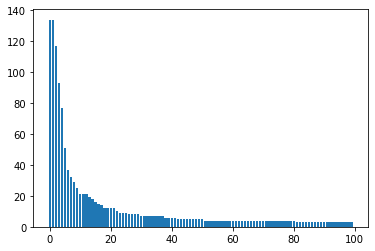

In [54]:
from matplotlib import pyplot as plt
import numpy as np
#fig = plt.figure(figsize =(12, 9))
plt.bar(range(0,100),EntAttr[0:100])
plt.show()